<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21222740/%F0%9F%9B%92GRU_with_600000_datasamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5 classes fine-grained Text Classification Amazon Reviews  GRU**


1. Loading Dataset (Amazon Reviews)
2. Download and Imports
3. Splitting it into training and testing sets.
4. Preprocessing the data (tokenizing and padding).
5. Building and training the model.
6. DTesting the model on the test dataset.


In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T150806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0384286882e57ed5979a453d3b36e2d5ac7c5683c21364a514272ce697b7a7430176301d285f6982230aa12ded3cf24f63136365e5939a1b4cf6a627f90b21b558772ac2b852ceeda8c9115147d5d45101662dbded2dc256b64c8607b23b8a2e138946585e223ab27c2e6ced66542d64b390b7a29fb5f28667574314b9b5d6a1e728981f43b957023ed099b2adfc9609101a051eb013f254b576ffd5c986f20ab81845f69f45dcde2f9c5e05f1e3fc15e3aed90b0112a274ad37e14053eb8e6d8635f649c8362c1478bc8b587d074f6474c488f679d16695f5ed6a20ddea00f6dc13ab4b1746b75013f78e36b46727d42ca74c2ba6b6d35bd214cd27c5751ebb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


#  Step 1: Load the Dataset

In [6]:
# Step 1: Load and Preview the Dataset

import pandas as pd

# Load the dataset (adjust the file path as necessary)
data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')

# Reduce the dataset to a manageable size
data  = data.sample(n=600000, random_state=42)

# Preview the dataset
data.head()


,class_index,review_title,review_text
2945667,4,Not Koontz's best but good read.,"Really, I should give it three and a half star..."
2352586,4,addictive--except for the price,mmmmmmm. Love this balm. Smells divine and mak...
1531260,2,Same problem,"Pitch Black plays perfectly, but for some reas..."
941910,1,Just say no to Slim-fast low carb shakes,I am currently on a Slim-fast diet and found i...
2582125,5,Happy Thanksgiving Turkey,I'm not much on writing reviews so I will be b...


#  

#  Step 2: Check for Missing Values

In [7]:
# Step 2: Check for Missing Values

# Check if there are any missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)

# Optionally, remove missing values if any
data.dropna(inplace=True)


class_index      0
review_title    45
review_text      0
dtype: int64


#

#  Step 3: Clean the Text Data

In [8]:
# Step 3: Clean the Text Data

import re

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply the clean_text function to both review_title and review_text columns
data['review_text'] = data['review_text'].apply(clean_text)
data['review_title'] = data['review_title'].apply(clean_text)

# Preview cleaned text
data[['review_title', 'review_text']].head()


,review_title,review_text
2945667,not koontzs best but good read,really i should give it three and a half stars...
2352586,addictiveexcept for the price,mmmmmmm love this balm smells divine and makes...
1531260,same problem,pitch black plays perfectly but for some reaso...
941910,just say no to slimfast low carb shakes,i am currently on a slimfast diet and found it...
2582125,happy thanksgiving turkey,im not much on writing reviews so i will be br...


#  Step 4: Tokenize and Pad Sequences

In [9]:
# Step 4: Tokenize and Pad Sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Limit to top 5000 words
tokenizer.fit_on_texts(data['review_text'])  # Fit on review text

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['review_text'])

# Pad the sequences to ensure uniform length
maxlen = 100  # Choose an appropriate max length
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')

# Convert class index to labels
labels = data['class_index'] - 1  # Assuming class index ranges from 1 to 5

# Display shape of padded sequences and labels
print(padded_sequences.shape)
print(labels.shape)


(599955, 100)
(599955,)


# Step 5: Check Class Balance

In [10]:
# Step 5: Check Class Balance

# Check class distribution
class_distribution = data['class_index'].value_counts()
print(class_distribution)


class_index
1    120252
5    120173
3    119885
4    119846
2    119799
Name: count, dtype: int64


# Step 6: Visualize Class Balance with matplotlib

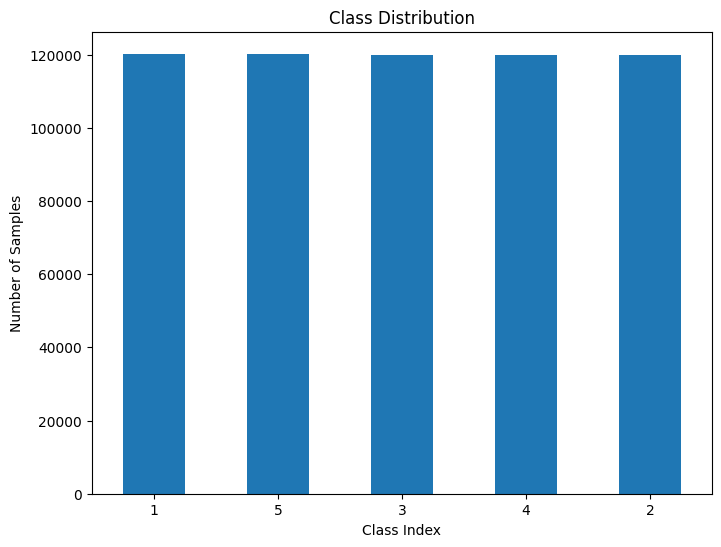

In [11]:
# Step 6: Visualize Class Balance

import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()


# Step 8: Build the GRU Model

In [12]:
# Step 8: Build the GRU Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Add embedding layer (input_dim should be vocab size + 1, as tokenizer starts from 1)
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))

# Add GRU layer
model.add(GRU(128, return_sequences=False))  # You can try different GRU units

# Add dropout to prevent overfitting
model.add(Dropout(0.5))

# Add dense layer for classification
model.add(Dense(5, activation='softmax'))  # 5 classes, so use softmax

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Step 9: Train the GRU Model

In [ ]:
# Step 9: Train the GRU Model

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/5
1451/7500 ━━━━━━━━━━━━━━━━━━━━ 24:06 239ms/step - accuracy: 0.2262 - loss: 1.5941

# Step 10: Plot Training History

In [ ]:
# Step 10: Plot Training and Validation Accuracy and Loss

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
